In [ ]:
#In this notebook we would classify dogs and cats using pytorch framework with the help of Convolutional Neural Network 
# Alex net network. First we would load data into our notebook.
# We would first load our data and apply various forms of transformations using torchvision.transforms module
# Afterwards, we would be shuffling our data with the help of train_loader 
# After performing transformations we would build our own convolutional neural network 
# After that we would also utilize alexnet to classify images of dogs and cats.
# Plus we would just amend the sequential part of the Alexnet in order to match the classification of dogs and cats.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [3]:
test_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [4]:
train_data=datasets.ImageFolder(root=("C:/Users/mashood/Desktop/New folder/Pytorch Full course udemy/PYTORCH_NOTEBOOKS/03-CNN-Convolutional-Neural-Networks/CATS_DOGS/train"),transform=train_transform)

In [5]:
test_data=datasets.ImageFolder(root=("C:/Users/mashood/Desktop/New folder/Pytorch Full course udemy/PYTORCH_NOTEBOOKS/03-CNN-Convolutional-Neural-Networks/CATS_DOGS/test"),transform=test_transform)

In [6]:
class_names=train_data.classes

In [7]:
class_names
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)

test_loader=DataLoader(test_data,batch_size=10)

In [8]:
len(train_data)

8908

In [9]:
len(test_data)

3899

In [10]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [1 1 0 0 0 1 1 1 1 0]
Class: DOG DOG CAT CAT CAT DOG DOG DOG DOG CAT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


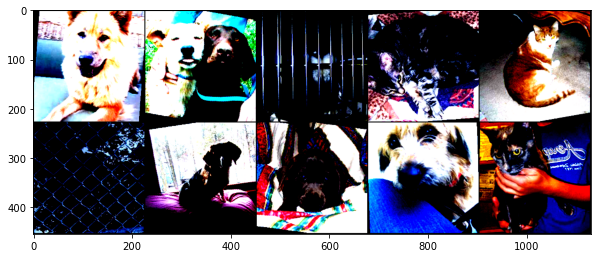

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [12]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                 std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

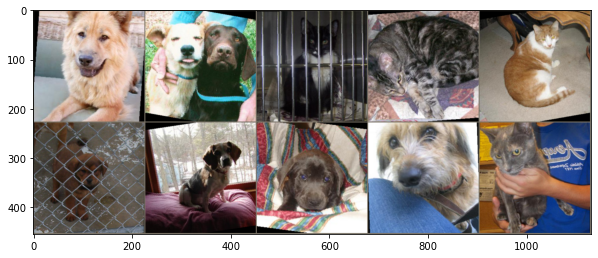

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [14]:
class ConvolutionalNetwork(nn.Module): #Building our own convolutional neural network
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(16*54*54,120)  #building with 120 neurons
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,2)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)
        
        return F.log_softmax(X, dim=1)
            
    

In [15]:
CNNmodel=ConvolutionalNetwork()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001) #We would be using adam as an optimizer

In [16]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=2, bias=True)
)

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
      40
       2
________
 5611794


In [18]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=5
for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):  #Training our model on images and then testing our model with
        b+=1                                              # test batch sizes.
        y_pred=CNNmodel(X_train)
        loss=criterion(y_pred,y_train)
        #true predictions
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        #update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print interim results
        if b%200==0:
            print(f"epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=CNNmodel(X_test)
            loss=criterion(y_val,y_test)
            
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')    

epoch: 0 loss: <built-in method item of Tensor object at 0x000001AAA4B1D4F8> batch: 200
epoch: 0 loss: <built-in method item of Tensor object at 0x000001AAA4B1D4F8> batch: 400
epoch: 0 loss: <built-in method item of Tensor object at 0x000001AAA4B1DD68> batch: 600
epoch: 0 loss: <built-in method item of Tensor object at 0x000001AAA4B1D368> batch: 800
epoch: 1 loss: <built-in method item of Tensor object at 0x000001AAA4B1D098> batch: 200
epoch: 1 loss: <built-in method item of Tensor object at 0x000001AAA4B1D098> batch: 400
epoch: 1 loss: <built-in method item of Tensor object at 0x000001AAA4B1D098> batch: 600
epoch: 1 loss: <built-in method item of Tensor object at 0x000001AAA4B1D098> batch: 800
epoch: 2 loss: <built-in method item of Tensor object at 0x000001AAA4B1DCC8> batch: 200
epoch: 2 loss: <built-in method item of Tensor object at 0x000001AAA4B1DA48> batch: 400
epoch: 2 loss: <built-in method item of Tensor object at 0x000001AAA4B1D908> batch: 600
epoch: 2 loss: <built-in method 

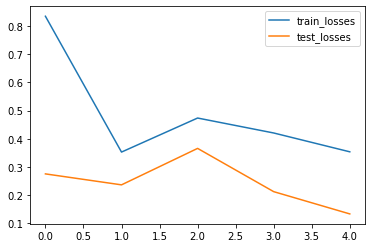

In [19]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

In [20]:
#Using alexnet model to predict whether they are cats or dogs
alexnetmodel= models.alexnet(pretrained=True)

In [21]:
alexnetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
for param in alexnetmodel.parameters():
    param.requires_grad=False

In [23]:
torch.manual_seed(42)

alexnetmodel.classifier=nn.Sequential(nn.Linear(9216,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,2),
                                     nn.LogSoftmax(dim=1))
alexnetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [24]:
count_parameters(alexnetmodel)

 9437184
    1024
    2048
       2
________
 9440258


In [25]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alexnetmodel.classifier.parameters(),lr=0.001)

In [26]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
trn_correct=[]
tst_correct=[]

epochs=5
for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        
        y_pred=alexnetmodel(X_train)
        loss=criterion(y_pred,y_train)       
        #Update parameters
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
                  
            y_val=alexnetmodel(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
    
    
    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)
                  
                  
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')        

epoch:  0  batch:  200 [  2000/8000]  loss: 0.05320126  accuracy:  87.900%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.10502593  accuracy:  90.375%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.34110296  accuracy:  91.500%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.10095187  accuracy:  91.838%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.08888600  accuracy:  94.300%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.18465877  accuracy:  94.025%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.05493302  accuracy:  93.817%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.05267788  accuracy:  93.700%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.05856695  accuracy:  94.050%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.03237443  accuracy:  93.950%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.51596016  accuracy:  94.300%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.14805128  accuracy:  94.175%
epoch:  3  batch:  200 [  2000/8000]  loss: 0.34069028  accuracy:  94.150%
epoch:  3  batch:  400 [ 

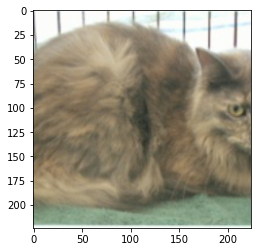

In [27]:
x=2021
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [28]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [30]:
#Evaluating our CNN model 
CNNmodel.eval()
with torch.no_grad():
    new_pred=CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [31]:
# Evaluating our alexnet model
alexnetmodel.eval()
with torch.no_grad():
    new_pred_1=alexnetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [ ]:
# Thus we can easily conclude that the accuracy of our convolutional network is _____
# Accuracy of alexnet is 95.70%
#THus both the networks perform well on this data.